## <font color='black'>Purpose: 
Wouldn't it be amazing if you could be certain your marriage will be successful?
Let us help you figure out if this is the right person for you!</font>

### <font color='gray'>What You Need to Do:
    Simply answer a few quick questions and we will predict if you're destined for marital bliss.

In [2]:
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

/Users/sowmyamurali/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/sowmyamurali/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
fileName = 'marriage.csv'
marriage_raw = pd.read_csv(fileName, header =0)

In [4]:
marriage_raw.shape

(2020, 163)

In [5]:
#select the columns we want
marriage1 = marriage_raw[['m2','state','usr1','spouse','qs1','marital','m4','lwp3','e3','q1','q15a','q15b','q15c','q15d','q15e','q15f','q15g','q15h','q15i','q16','e5','fam2','ownrent','relig','income','ideo','receduc','racethn']]

In [6]:
#rename columns so we can understand
marriage1 = marriage1.rename(columns={'m2':'everMarried','state': 'state', 'usr1': 'community', 'spouse': 'whichSpouse', 'qs1': 'age', 'marital': 'marriageStatus', 'm4': 'everDivorced', 'lwp3': 'livedTogether', 'e3': 'employment', 'q1': 'lifeSatisfaction','q15a':'faithfulness','q15b':'adeqIncome', 'q15c':'shareRelig', 'q15d':'goodHouse', 'q15e':'agreePolitics', 'q15f':'goodSexLife', 'q15g':'shareChores', 'q15h':'children', 'q15i':'commonInterests', 'q16':'divorceViews', 'e5':'spouseEmployment', 'fam2':'parentMaritalStatus', 'ownrent':'ownrent', 'relig':'religion', 'income':'incomepastyr', 'ideo':'politicalViews', 'receduc':'educationLevel', 'raceeth':'racethn'})

In [7]:
#move everDivorced to end since it is the target
features = list(marriage1.columns.values)
features.pop(features.index('marriageStatus'))
features.pop(features.index('everDivorced'))
marriage1 = marriage1[['marriageStatus']+features+['everDivorced']]

In [8]:
#the only rows that have 0 as a valid value are q15a-i
#therefore set all blank values in the remaining columns to 0s
marriage1 = marriage1.replace(' ', np.nan)

In [9]:
marriage1 = marriage1.apply(pd.to_numeric, errors='ignore')

In [10]:
#remove all rows where MarriageStatus = 6 - never been married or 9 - don't know/refused
marriage1 = marriage1.drop(marriage1[(marriage1.marriageStatus == 6) | (marriage1.marriageStatus == 9)].index)

In [11]:
#for all rows where marriage status is 3 - divorced or 4 - separated enter 1 in everDivorced
marriage1.loc[marriage1['marriageStatus'] == 3, 'everDivorced'] = 1
marriage1.loc[marriage1['marriageStatus'] == 4, 'everDivorced'] = 1

In [12]:
#for all rows where everMarried = 1 and marriage status = 2 enter 1 in everDivorced
#we are assuming here that if you've been married and current status is living together then you've been divorced
marriage1.loc[(marriage1['everMarried']==1) & (marriage1['marriageStatus']==2),'everDivorced'] = 1

In [13]:
#for all rows where marriage status is 1 - married or 2 - living together or 5 - widowed enter 0 in everDivorced
marriage1.loc[((marriage1['marriageStatus'].isin([1,2,5])) & (marriage1['everDivorced'].isnull())),'everDivorced'] = 0

In [14]:
marriage1.loc[marriage1['everDivorced'] == 2, 'everDivorced'] = 0

In [15]:
#check the values of everDivorced
marriage1['everDivorced'].unique()

array([ 0.,  1.])

In [16]:
#new number of rows and columns
marriage1.shape

(1594, 28)

In [17]:
#the features are everything but everdivorced, maritial status and everMarried
features =  list(marriage1.columns[2:27])

In [18]:
%matplotlib inline

In [19]:
# how many responses per state
# 1│Urban   
# 2│Suburban
# 3│Rural   
marriage1['community'].value_counts()

2    678
1    644
3    272
Name: community, dtype: int64

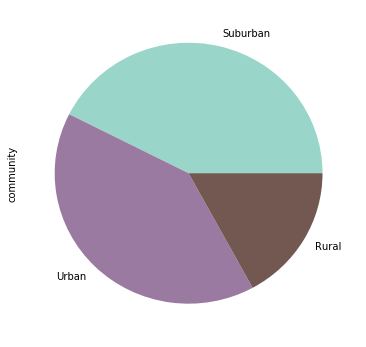

In [20]:
marriage1['community'].value_counts().plot(kind='pie',labels=['Suburban','Urban','Rural'],colors=['#9AD5CA', '#9A7AA0','#735751'], figsize=(6, 6))

In [21]:
#how many responses per age group
# 1│18 to 49          
# 2│50 to 64    
# 3│65 and older?     
# 9│Don't know/Refused

marriage1['age'].value_counts()

1.0    272
2.0     11
3.0      3
Name: age, dtype: int64

In [57]:
#how many people women vs men are divorced
#1 wife 2 husband
marriage1.groupby(by=[marriage1.whichSpouse,marriage1.everDivorced, ])['whichSpouse'].count()

whichSpouse  everDivorced
1.0          0.0             388
             1.0             101
2.0          0.0             411
             1.0             113
Name: whichSpouse, dtype: int64

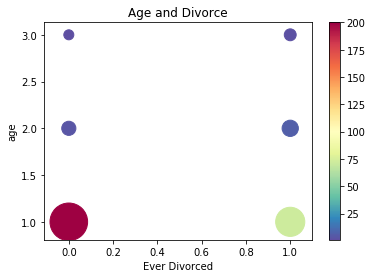

In [23]:
test_x = marriage1['everDivorced']
test_y = marriage1['age']
points=list(set(zip(test_x,test_y))) 
#Generate a list of point counts
count=[len([x for x,y in zip(test_x,test_y) if x==p[0] and y==p[1]]) for p in points]
#lotting:
plot_x=[i[0] for i in points]
plot_y=[i[1] for i in points]
count=np.array(count)
plt.scatter(plot_x,plot_y,c=count,s=100*count**0.5,cmap='Spectral_r')
plt.colorbar()
plt.title('Age and Divorce')
plt.xlabel('Ever Divorced')
plt.ylabel('age')
plt.show()

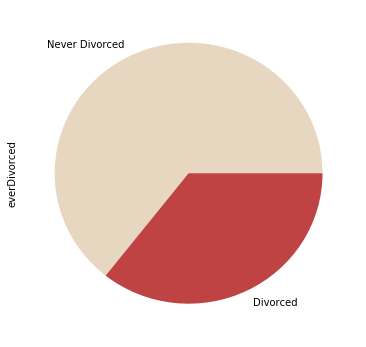

In [30]:
#ratio of divorced vs not divorced people
marriage1['everDivorced'].value_counts().plot(kind='pie',labels=['Never Divorced', 'Divorced'],colors=['#E7D7C1', '#BF4342'], figsize=(6, 6))

([<matplotlib.axis.XTick at 0x1c22900f60>,
 <a list of 5 Text xticklabel objects>)

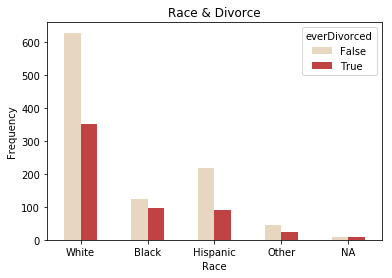

In [59]:
#barplot of marriage rating grouped by race 
# 1 White 2 Black 3 Hispanic 4 Other 9 Don't Know

pd.crosstab(marriage1.racethn, \

marriage1.everDivorced.astype(bool)).plot(kind='bar',color=['#E7D7C1', '#BF4342']) 
plt.title('Race & Divorce') 
plt.xlabel('Race') 
plt.ylabel('Frequency')
plt.xticks(range(5), ('White', 'Black', 'Hispanic','Other','NA'),rotation=0)

([<matplotlib.axis.XTick at 0x1c227d05c0>,
 <a list of 4 Text xticklabel objects>)

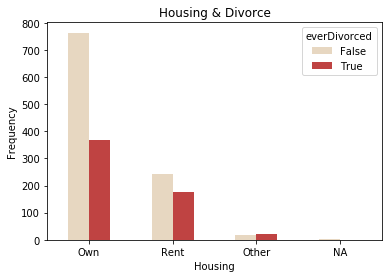

In [58]:
# 1 Own 2 Rent 3 Other Arrangement 9 Don't know

pd.crosstab(marriage1.ownrent, \

marriage1.everDivorced.astype(bool)).plot(kind='bar',color=['#E7D7C1', '#BF4342']) 
plt.title('Housing & Divorce') 
plt.xlabel('Housing') 
plt.ylabel('Frequency')
plt.xticks(range(4), ('Own', 'Rent', 'Other','NA'),rotation=0)

([<matplotlib.axis.XTick at 0x1c1fbe8860>,
 <a list of 5 Text xticklabel objects>)

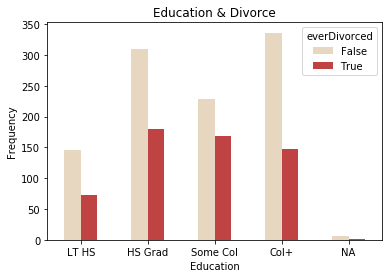

In [56]:
# │    1│LT HS    │
# │    2│HS GRAD  │
# │    3│SOME COLL│
# │    4│COLLEGE+ │
# │    9│REF      |
labels =['LT HS', 'HS Grad','Some Col','Col+','NA']
pd.crosstab(marriage1.educationLevel, \

marriage1.everDivorced.astype(bool)).plot(kind='bar',color=['#E7D7C1', '#BF4342']) 
plt.title('Education & Divorce') 
plt.xlabel('Education') 
plt.ylabel('Frequency')
plt.xticks(range(5), ('LT HS', 'HS Grad','Some Col','Col+','NA'),rotation=0)

([<matplotlib.axis.XTick at 0x1c1fc29438>,
 <a list of 3 Text xticklabel objects>)

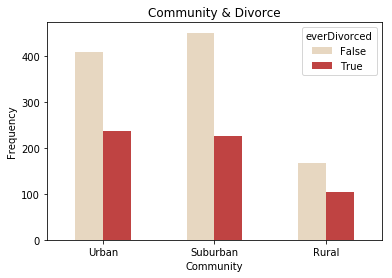

In [54]:
# 1│Urban   
# 2│Suburban
# 3│Rural

pd.crosstab(marriage1.community, \

marriage1.everDivorced.astype(bool)).plot(kind='bar',color=['#E7D7C1', '#BF4342']) 
plt.title('Community & Divorce') 
plt.xlabel('Community') 
plt.ylabel('Frequency')
plt.xticks(range(3), ('Urban', 'Suburban', 'Rural'),rotation=0)

Text(0,0.5,'Frequency')

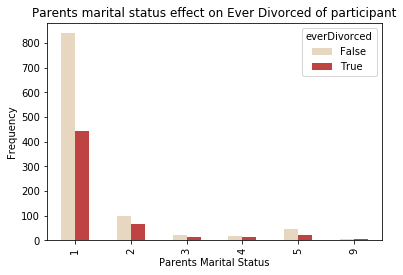

In [25]:
#barplot of marriage rating grouped by parental divorce history (True or False)
#parentMarital Status 1 Married 2 Divorced 3 Separated 4 Widowed 5 Never married 9 Don't know/Refused
pd.crosstab(marriage1.parentMaritalStatus, \

marriage1.everDivorced.astype(bool)).plot(kind='bar',color=['#E7D7C1', '#BF4342']) 
plt.title('Parents marital status effect on Ever Divorced of participant') 
plt.xlabel('Parents Marital Status') 
plt.ylabel('Frequency')